# Transfer learning and fine-tuning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

### Data Download

In [2]:
!pip install opendatasets
!pip install pandas
import opendatasets as od
import pandas

#"username":"azizalexandrostarek","key":"e45b32156c23b826f54ec9475f12056a"
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")


Skipping, found downloaded files in ".\chest-xray-pneumonia" (use force=True to force download)


## Data preprocessing

In [3]:
PATH = ".\chest-xray-pneumonia\chest_xray"


train_dir = os.path.join(PATH, 'train')

validation_dir = os.path.join(PATH, 'val')

#Chestxray includes this file otherwise data splitting would have been be used
test_dir = os.path.join(PATH, 'test')


BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 5216 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 16 files belonging to 2 classes.


In [5]:
#added test
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 624 files belonging to 2 classes.


Show the first 16 images and labels from the training set:

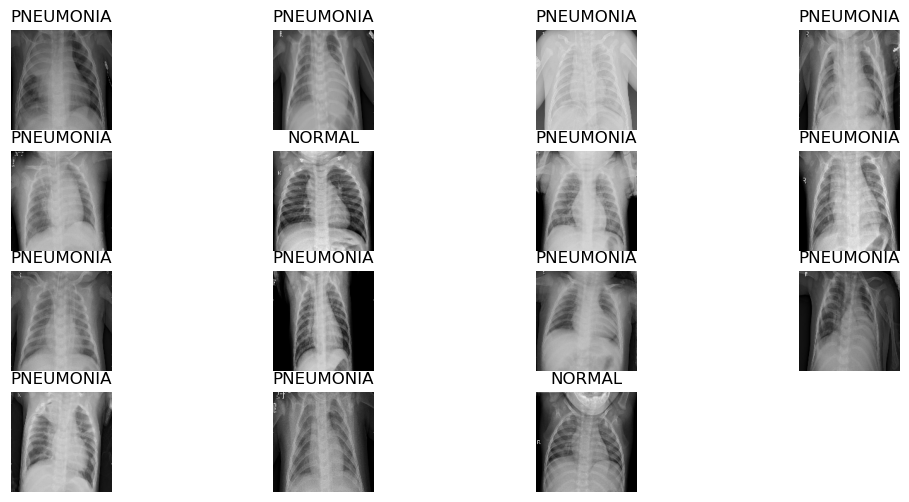

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(13, 6))
for images, labels in train_dataset.take(1):
  for i in range(15):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

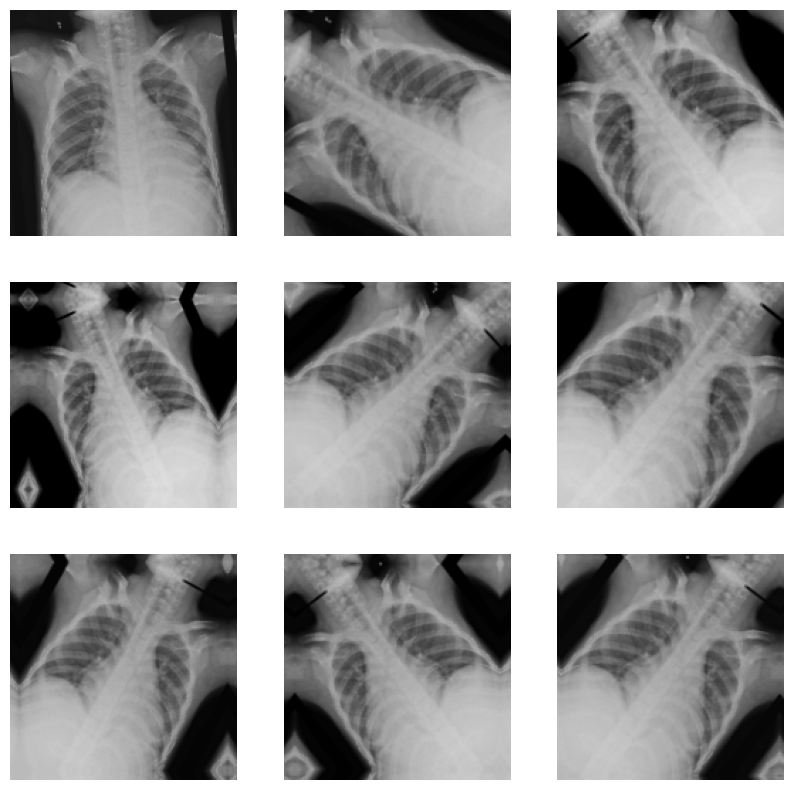

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [11]:
rescale = tf.keras.layers.Rescaling(1./130, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 512)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [14]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0     

The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [20]:
len(model.trainable_variables)

2

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

### Train the model


In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


1/1 [==============================] - 1s 793ms/step - loss: 0.7328 - accuracy: 0.4375


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.73
initial accuracy: 0.44


In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
163/163 [==============================] - 169s 1s/step - loss: 0.6584 - accuracy: 0.6202 - val_loss: 0.7794 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 186s 1s/step - loss: 0.5871 - accuracy: 0.7320 - val_loss: 0.8278 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 197s 1s/step - loss: 0.5697 - accuracy: 0.7416 - val_loss: 0.8359 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 162s 989ms/step - loss: 0.5632 - accuracy: 0.7427 - val_loss: 0.8296 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 180s 1s/step - loss: 0.5517 - accuracy: 0.7437 - val_loss: 0.8183 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 190s 1s/step - loss: 0.5362 - accuracy: 0.7435 - val_loss: 0.8064 - val_accuracy: 0.5000
Epoch 7/10
163/163 [==============================] - 187s 1s/step - loss: 0.5290 - accuracy: 0.7441 - val_loss: 0.7928 - val_accuracy: 0.5

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

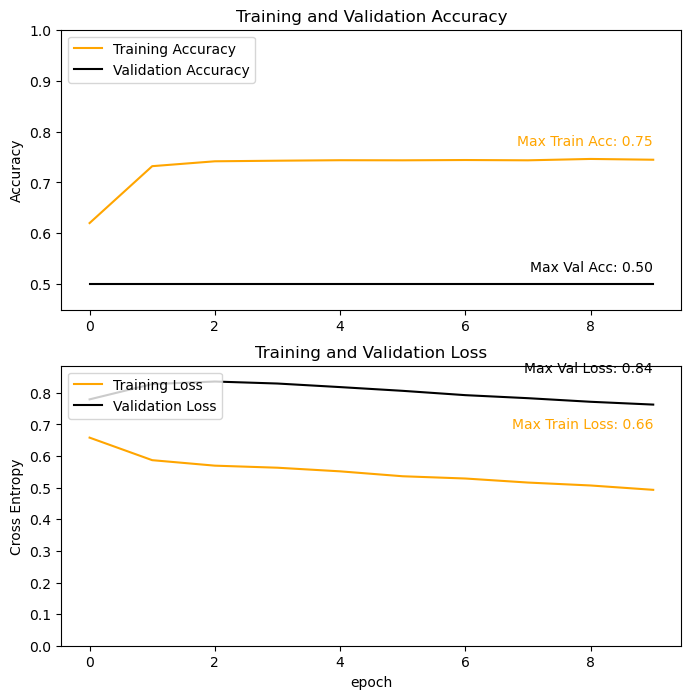

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='orange')  # Training Accuracy in orange
plt.plot(val_acc, label='Validation Accuracy', color='black')  # Validation Accuracy in black
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(min(acc), min(val_acc)) - 0.05, 1])  # Adjusting ylim for accuracy plot
plt.title('Training and Validation Accuracy')

min_train_acc = min(acc)
max_train_acc = max(acc)
min_val_acc = min(val_acc)
max_val_acc = max(val_acc)

# Annotating the lowest and highest values for accuracy
plt.text(len(acc) - 1, max_train_acc + 0.02, f"Max Train Acc: {max_train_acc:.2f}", ha='right', va='bottom', color='orange')
plt.text(len(val_acc) - 1, max_val_acc + 0.02, f"Max Val Acc: {max_val_acc:.2f}", ha='right', va='bottom', color='black')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='orange')  # Training Loss in orange
plt.plot(val_loss, label='Validation Loss', color='black')  # Validation Loss in black
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(max(loss), max(val_loss)) + 0.05])  # Adjusting ylim for loss plot
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

min_train_loss = min(loss)
max_train_loss = max(loss)
min_val_loss = min(val_loss)
max_val_loss = max(val_loss)

# Annotating the lowest and highest values for loss
plt.text(len(loss) - 1, max_train_loss + 0.02, f"Max Train Loss: {max_train_loss:.2f}", ha='right', va='bottom', color='orange')
plt.text(len(val_loss) - 1, max_val_loss + 0.02, f"Max Val Loss: {max_val_loss:.2f}", ha='right', va='bottom', color='black')

plt.show()


## Fine tuning


### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0     

In [31]:
len(model.trainable_variables)

2

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [32]:
fine_tune_epochs = 14
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/24
163/163 [==============================] - 143s 870ms/step - loss: 0.4876 - accuracy: 0.7469 - val_loss: 0.7622 - val_accuracy: 0.5000
Epoch 11/24
163/163 [==============================] - 142s 872ms/step - loss: 0.4856 - accuracy: 0.7475 - val_loss: 0.7620 - val_accuracy: 0.5000
Epoch 12/24
163/163 [==============================] - 142s 871ms/step - loss: 0.4883 - accuracy: 0.7475 - val_loss: 0.7616 - val_accuracy: 0.5000
Epoch 13/24
163/163 [==============================] - 143s 876ms/step - loss: 0.4898 - accuracy: 0.7471 - val_loss: 0.7610 - val_accuracy: 0.5000
Epoch 14/24
163/163 [==============================] - 602s 4s/step - loss: 0.4847 - accuracy: 0.7488 - val_loss: 0.7604 - val_accuracy: 0.5000
Epoch 15/24
163/163 [==============================] - 193s 1s/step - loss: 0.4886 - accuracy: 0.7471 - val_loss: 0.7590 - val_accuracy: 0.5000
Epoch 16/24
163/163 [==============================] - 197s 1s/step - loss: 0.4826 - accuracy: 0.7469 - val_loss: 0.7587 - v

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

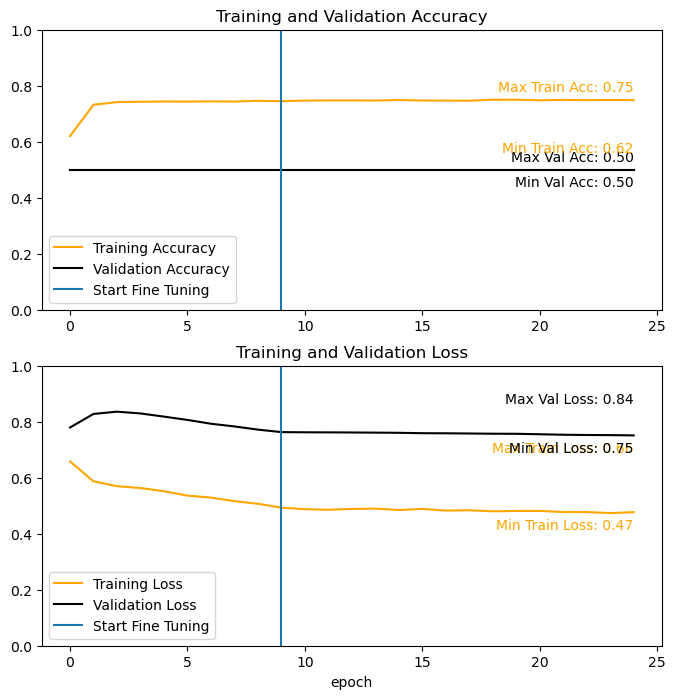

In [34]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='orange')  # Training Accuracy in orange
plt.plot(val_acc, label='Validation Accuracy', color='black')  # Validation Accuracy in black
plt.ylim([0, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

min_train_acc = min(acc)
max_train_acc = max(acc)
min_val_acc = min(val_acc)
max_val_acc = max(val_acc)

# Annotating the lowest and highest values for accuracy
plt.text(len(acc) - 1, max_train_acc + 0.02, f"Max Train Acc: {max_train_acc:.2f}", ha='right', va='bottom', color='orange')
plt.text(len(val_acc) - 1, max_val_acc + 0.02, f"Max Val Acc: {max_val_acc:.2f}", ha='right', va='bottom', color='black')
plt.text(len(acc) - 1, min_train_acc - 0.02, f"Min Train Acc: {min_train_acc:.2f}", ha='right', va='top', color='orange')
plt.text(len(val_acc) - 1, min_val_acc - 0.02, f"Min Val Acc: {min_val_acc:.2f}", ha='right', va='top', color='black')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='orange')  # Training Loss in orange
plt.plot(val_loss, label='Validation Loss', color='black')  # Validation Loss in black
plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

min_train_loss = min(loss) if isinstance(loss, list) else loss
max_train_loss = max(loss) if isinstance(loss, list) else loss
min_val_loss = min(val_loss) if isinstance(val_loss, list) else val_loss
max_val_loss = max(val_loss) if isinstance(val_loss, list) else val_loss

# Annotating the lowest and highest values for loss
plt.text(len(loss) - 1, max_train_loss + 0.02, f"Max Train Loss: {max_train_loss:.2f}", ha='right', va='bottom', color='orange')
plt.text(len(val_loss) - 1, max_val_loss + 0.02, f"Max Val Loss: {max_val_loss:.2f}", ha='right', va='bottom', color='black')
plt.text(len(loss) - 1, min_train_loss - 0.02, f"Min Train Loss: {min_train_loss:.2f}", ha='right', va='top', color='orange')
plt.text(len(val_loss) - 1, min_val_loss - 0.02, f"Min Val Loss: {min_val_loss:.2f}", ha='right', va='top', color='black')

plt.show()


### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

20/20 [==============================] - 24s 1s/step - loss: 0.6151 - accuracy: 0.6250
Test accuracy : 0.625


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0]


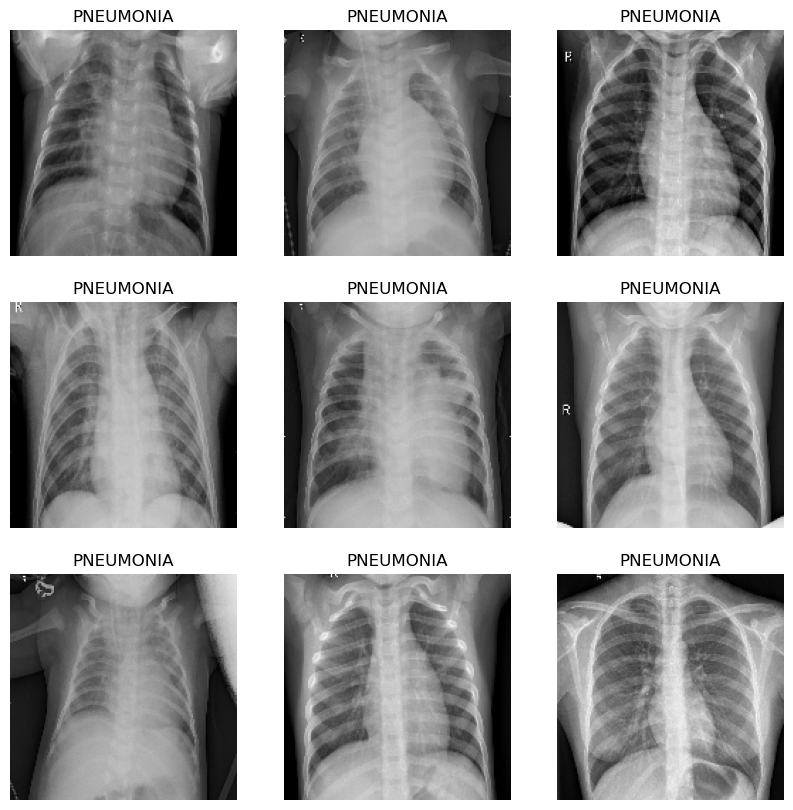

In [36]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")